In [84]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

file_names = ['MCTS-Results', 'OMCTS-Results', 'DDO-MCTS-Results']
file_names = ['MCTS-Results', 'OMCTS-Redone-Results-Synthesized', 'DDO-MCTS-Results']
num_games = 12
controllers = ['MCTS' , 'O-MCTS', 'DDO-MCTS']
# file_names = ['controller_gamma_honours_results', '90_gamma_honours_results', '95_gamma_honours_results']
# num_games = 7
# controllers = ['$\gamma_d = 0.9$' , '$\gamma_f = 0.9$', '$\gamma_f = 0.95$']

WIN_RATIO_MODE = False
output_file_name = 'mean_scores_main'
graph_title = 'Normalised Mean Scores by Controller'

In [85]:
def read_results(file_name):
    result_patt = r'Result \(1->win; 0->lose\): Player0:([-]*[0-9]+), Player0-Score:([-]*[0-9]+.[0-9]+), timesteps:([0-9]+)'
    game_patt = r'Game played: ([a-z]+)'
    curr_game = None
    
    res = {}
    count = 1
    tot_score = 0
    wins = 0
    losses = 0
    tot_timesteps = 0
    
    with open(file_name) as fd:
        for line in fd:
            game_match = re.search(game_patt, line, re.IGNORECASE)
            res_match = re.search(result_patt, line, re.IGNORECASE)
            if game_match is not None:
                curr_game = game_match.group(1)
                count = 1
                tot_score = 0
                wins = 0
                losses = 0
                tot_timesteps = 0
            if res_match is not None:
                outcome = float(res_match.group(1))
                player_score = float(res_match.group(2))
                timesteps = int(res_match.group(3))
                if outcome > 0:
                    wins += 1
                else:
                    losses += 1
                    
                tot_score += player_score
                tot_timesteps += timesteps
                count+=1
                if count > 100:
                    res[curr_game] = (wins, losses, tot_score/100, tot_timesteps/100)
                    
    return res


def normalize(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)
 
def get_stats(res):
    ratios = []
    scores = []
    timesteps = []
    names = []
    for game, (wins, losses, avg_score, avg_timesteps) in res.items():
        if wins == 0:
            ratios.append(0)
        elif losses == 0:
            ratios.append(1)
        else:
            ratios.append(wins/100)
        scores.append(avg_score)
        timesteps.append(avg_timesteps)
        names.append(game)
#         print(game)
#         print('Wins: ' + str(wins))
#         print('Losses: ' + str(losses))
#         print('Avg score: ' + str(avg_score))
#         print('Avg timesteps: ' + str(avg_timesteps))
#     norm_scores = 
#     print(scores)
#     print(norm_scores)

    return (ratios, scores, timesteps, names)

def graph_results(files, nm_gms, setting, output_name, plt_title, rotate_label=0):
    
    stats = []
    for file in files:
        dic = read_results(file)
        stats.append(get_stats(dic))
    
    print("FIRST STATS")
    print(stats)
    
    game_avg_scores = {}
    for stat in stats:
        for i, game in enumerate(stat[3]):
            avg_score = stat[1][i]
            if game not in game_avg_scores:
                score_list = [avg_score]
                game_avg_scores[game] = score_list
            else:
                score_list = game_avg_scores[game]
                score_list.append(avg_score)
                game_avg_scores[game] = score_list
    
    i = 0
    
    for key, scores in game_avg_scores.items():
        normalized_scores = normalize(scores)[0]
        for j, new_score in enumerate(normalized_scores):
            curr_agent_scores = stats[j][1]
            curr_agent_scores[i] = new_score
            stats[j] = (stats[j][0], curr_agent_scores, stats[j][2], stats[j][3])
            
        i+=1
            
    print("SECOND STATS")
    print(stats)
    
    bar_width = 0.25
    r1 = np.arange(nm_gms)
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    i = 0
    fig, ax = plt.subplots(figsize=(18,7))
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
    mpl.rc('font', **font)
    
    print("THIRD STATS")
    print(stats[1])
    for stat in stats:
        if i == 0:
            r = r1
        elif i== 1:
            r = r2
        elif i == 2:
            r = r3
        
        if setting:
            data = stat[0]
        else:
            data = stat[1]
        plt.bar(r, height=data, width=bar_width, label=controllers[i])
        ax.legend(fontsize=14)
        plt.xticks(np.arange(nm_gms), stat[3], rotation=rotate_label)
        if setting:
            plt.ylabel('Win Ratio out of 100 Games')
        else:
            plt.ylabel('Normalized Mean Score out of 100 Games')
        i+=1
    plt.title(plt_title)
    plt.savefig(output_name + '.pdf')


#         if i == 0:
#             r = r1
#         elif i== 1:
#             r = r2
#         elif i == 2:
#             r = r3
        
#         if setting:
#             data = stats[0]
#         else:
#             data = stats[1]
#         plt.bar(r, height=data, width=bar_width, label=controllers[i])
#         ax.legend(fontsize=14)
#         plt.xticks(np.arange(nm_gms), stats[3], rotation=rotate_label)
#         if setting:
#             plt.ylabel('Win Ratio out of 100 Games')
#         else:
#             plt.ylabel('Normalized Mean Score out of 100 Games')
#         i+=1
#     plt.title(plt_title)
#     plt.savefig(output_name + '.pdf')  
    
# def get_stats(res):
#     ratios = []
#     scores = []
#     timesteps = []
#     names = []
#     for game, (wins, losses, avg_score, avg_timesteps) in res.items():
#         if wins == 0:
#             ratios.append(0)
#         elif losses == 0:
#             ratios.append(1)
#         else:
#             ratios.append(wins/100)
#         scores.append(avg_score)
#         timesteps.append(avg_timesteps)
#         names.append(game)
# #         print(game)
# #         print('Wins: ' + str(wins))
# #         print('Losses: ' + str(losses))
# #         print('Avg score: ' + str(avg_score))
# #         print('Avg timesteps: ' + str(avg_timesteps))
# #     norm_scores = 
# #     print(scores)
# #     print(norm_scores)

#     return (ratios, normalized(scores)[0], timesteps, names)

# def graph_results(files, nm_gms, setting, output_name, plt_title, rotate_label=0):
#     bar_width = 0.25
#     r1 = np.arange(nm_gms)
#     r2 = [x + bar_width for x in r1]
#     r3 = [x + bar_width for x in r2]
#     i = 0
#     fig, ax = plt.subplots(figsize=(18,6))
#     font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}
#     mpl.rc('font', **font)
#     for file in files:
#         dic = read_results(file)
#         stats = get_stats(dic)
#         if i == 0:
#             r = r1
#         elif i== 1:
#             r = r2
#         elif i == 2:
#             r = r3
        
#         if setting:
#             data = stats[0]
#         else:
#             data = stats[1]
#         plt.bar(r, height=data, width=bar_width, label=controllers[i])
#         ax.legend(fontsize=14)
#         plt.xticks(np.arange(nm_gms), stats[3], rotation=rotate_label)
#         if setting:
#             plt.ylabel('Win Ratio out of 100 Games')
#         else:
#             plt.ylabel('Normalized Mean Score out of 100 Games')
#         i+=1
#     plt.title(plt_title)
#     plt.savefig(output_name + '.pdf')

FIRST STATS
[([1, 0.97, 0.73, 0.07, 0.97, 0.13, 0, 0, 0.37, 0.04, 0.11, 0.05], [1.0, 16.16, 5.56, -0.73, 2873.36, 0.13, 102.39, 4.46, 4.59, 3.34, 16.44, 0.05], [0.03, 670.16, 146.28, 436.82, 991.48, 397.02, 520.86, 1220.08, 1676.81, 1872.18, 289.09, 1641.01], ['surround', 'infection', 'missilecommand', 'camelRace', 'seaquest', 'frogs', 'pacman', 'roguelike', 'zelda', 'chase', 'eggomania', 'portals']), ([1, 1, 0.96, 1, 0.76, 0.13, 0, 0, 0.43, 0.24, 0.38, 0.12], [1.0, 17.49, 8.13, 1.0, 3611.5, -59.87, -929.68, -369.15, 4.33, 4.03, 45.46, -69.88], [0.0, 439.26, 97.98, 47.16, 819.39, 294.66, 37.62, 257.07, 980.63, 562.62, 252.7, 236.49], ['surround', 'infection', 'missilecommand', 'camelRace', 'seaquest', 'frogs', 'pacman', 'roguelike', 'zelda', 'chase', 'eggomania', 'portals']), ([1, 1, 0.96, 1, 0.78, 0.18, 0, 0, 0.54, 0.24, 0.37, 0.06], [1.0, 16.19, 6.81, 1.0, 3580.87, -119.82, -929.65, -529.25, 4.4, 3.68, 50.33, -99.94], [0.0, 406.34, 99.56, 47.2, 834.31, 288.47, 45.9, 231.23, 856.01, 5

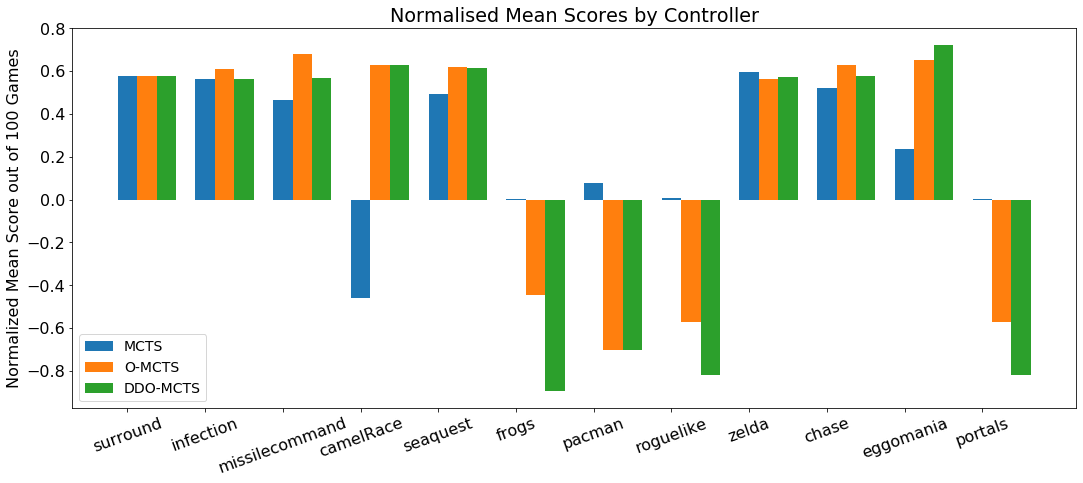

In [86]:
graph_results(file_names, num_games, WIN_RATIO_MODE, output_file_name, graph_title, 20)

'Result (1->win; 0->lose): Player0:1, Player0-Score:1.0, timesteps:0'

In [6]:
res = {}

with open(file_names[0]) as fd:
    line = fd.readline()
    count = 0
    wins = 0
    losses = 0
    tot_score = 0
    tot_timesteps = 0
    
    game_nm = 1
    
    while line is not '':
        match = re.search(r'Game played: ([a-z]+)')
        while match is None:
            match = re.search(r'Game played)
        match = re.search(pattern, line)
        if match is not None:
            if count > 99:
                count = 0
                res["game" + str(game_nm)] = (wins, losses, tot_score/100, tot_timesteps/100)
                wins = 0
                losses = 0
                tot_score = 0
                tot_timesteps = 0
                game_nm += 1
            player_won = match.group(1)
            if int(player_won) == 1:
                wins += 1
            else:
                losses += 1
                
            score = match.group(2)
            tot_score += float(score)
            
            timesteps = match.group(3)
            tot_timesteps += float(timesteps)
            
            count+=1
            
        line = fd.readline()
#     print(line)
#         match = re.search(pattern, line)
#         print(match.group(3))

print(res)

SyntaxError: EOL while scanning string literal (<ipython-input-6-372cbd4301e0>, line 16)

In [132]:
def get_ratios(res):
    ratios = []
    scores = []
    timesteps = []
    names = []
    for game, (wins, losses, avg_score, avg_timesteps) in res.items():
        if wins == 0:
            ratios.append(0)
        elif losses == 0:
            ratios.append(100)
        else:
            ratios.append(wins/losses)
        scores.append(avg_score)
        timesteps.append(avg_timesteps)
        names.append(game)
    #     print(game)
    #     print('Wins: ' + str(wins))
    #     print('Losses: ' + str(losses))
    #     print('Avg score: ' + str(avg_score))
    #     print('Avg timesteps: ' + str(avg_timesteps))

    return ratios

[100,
 100,
 100,
 100,
 100,
 9.0,
 0.26582278481012656,
 0.28205128205128205,
 49.0,
 0.6666666666666666,
 1.564102564102564,
 0.041666666666666664]

<BarContainer object of 12 artists>

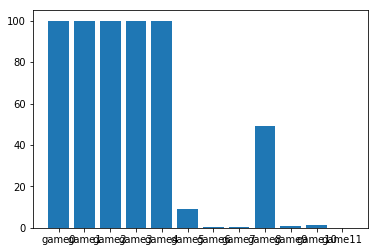

In [136]:
plt.bar(names, height=ratios)

<BarContainer object of 12 artists>

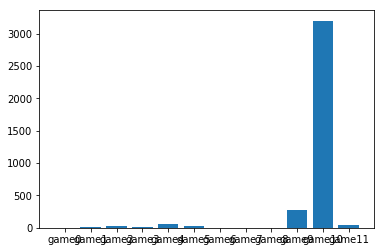

In [138]:
plt.bar(names, height=scores)

<BarContainer object of 12 artists>

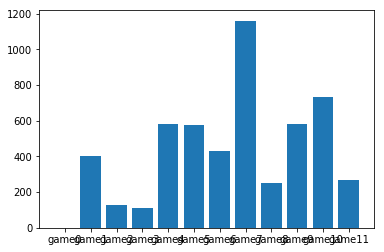

In [137]:
plt.bar(names, height=timesteps)